<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/05wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

{{<video https://youtu.be/playlist?list=PLQqh36zP38-xetJQU7iWPjyBchV8YrWO1&si=Nti_aqqC5fOyNOtP >}}

# 2. Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision
import fastai.data.all 

# 3. Data: MNIST

`-` download data 

In [2]:
path = fastai.data.external.untar_data('https://s3.amazonaws.com/fast-ai-imageclas/mnist_png.tgz')

`-` training set 

In [3]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1])/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

`-` test set 

In [4]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
XX = torch.concat([X0,X1])/255
yy = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

In [5]:
X.shape,XX.shape,y.shape,yy.shape

(torch.Size([12665, 1, 28, 28]),
 torch.Size([2115, 1, 28, 28]),
 torch.Size([12665, 1]),
 torch.Size([2115, 1]))

# 4. CNN 예비학습

## A. 기존모형에 대한 불만

![](https://guebin.github.io/DL2022/posts/III.%20CNN/2022-10-18-7wk-2_files/figure-html/cell-8-output-1.svg)

`-` 왜 28 $\times$ 28 이미지를 784개의 벡터로 만든 다음에 모형을 돌려야 하는가? 

`-` 기존에 개발된 모형이 회귀분석 기반으로 되어있어서 결국 회귀분석 틀에 짜 맞추어서 이미지자료를 분석하는 느낌 

`-` observation의 차원은 $784$가 아니라 $1\times (28\times 28)$이 되어야 맞다. 

## B. 새로운 아키텍처의 제시

`-` 예전 아키텍처들

- $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$
- $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,256)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,256)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$
- $\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,30)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,30)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

`-` 아키텍처들의 공통점? 

- $l_1$: 선형변환, feature를 뽑아내는 역할 (뻥튀기 혹은 요약)
- $relu$: 뻥튀기된 feature에 비선형을 추가하여 표현력 극대화 
- $l_2$: 선형변환, 뻥튀기된 feature를 요약 하는 역할 (=데이터를 요약하는 역할) 

`-` 새로운 아키텍처 

- $conv$: feature를 뽑아내는 역할 (뻥튀기 혹은 요약) (2d ver $l_1$ 느낌) 
- $relu$: 
- $pooling$: 데이터를 요약하는 역할 

## C. `torch.nn.Conv2d`

`-` 우선 연산하는 방법만 살펴보자. 

**(예시1)**

In [6]:
torch.manual_seed(43052)
conv = torch.nn.Conv2d(1,1,(2,2)) # 입력1, 출력1, (2,2) window size
conv.weight.data, conv.bias.data

(tensor([[[[-0.1733, -0.4235],
           [ 0.1802,  0.4668]]]]),
 tensor([0.2037]))

In [7]:
_X = torch.arange(0,4).reshape(1,1,2,2).float() # 2,2 흑백이미지. 
_X

tensor([[[[0., 1.],
          [2., 3.]]]])

In [8]:
(-0.1733)*0 + (-0.4235)*1 +\
(0.1802)*2 + (0.4668)*3 + 0.2037

1.541

In [9]:
conv(_X)

tensor([[[[1.5410]]]], grad_fn=<ConvolutionBackward0>)

**(예시2) 평균**

In [10]:
conv = torch.nn.Conv2d(1,1,(2,2))
conv.weight.data = conv.weight.data * 0 + 1/4
conv.bias.data = conv.bias.data * 0

In [11]:
_X

tensor([[[[0., 1.],
          [2., 3.]]]])

In [12]:
conv(_X)

tensor([[[[1.5000]]]], grad_fn=<ConvolutionBackward0>)

**(예시3) 이동평균?**

In [13]:
_X = torch.arange(16).reshape(1,1,4,4).float()
_X,conv(_X)

(tensor([[[[ 0.,  1.,  2.,  3.],
           [ 4.,  5.,  6.,  7.],
           [ 8.,  9., 10., 11.],
           [12., 13., 14., 15.]]]]),
 tensor([[[[ 2.5000,  3.5000,  4.5000],
           [ 6.5000,  7.5000,  8.5000],
           [10.5000, 11.5000, 12.5000]]]], grad_fn=<ConvolutionBackward0>))

**(예시4) window size가 증가한다면? (2d의 이동평균느낌)**

In [14]:
_X = torch.arange(16).reshape(1,1,4,4).float()
conv = torch.nn.Conv2d(1,1,(3,3))
conv.weight.data = conv.weight.data * 0 + 1/9
conv.bias.data = conv.bias.data * 0

In [15]:
_X,conv(_X)

(tensor([[[[ 0.,  1.,  2.,  3.],
           [ 4.,  5.,  6.,  7.],
           [ 8.,  9., 10., 11.],
           [12., 13., 14., 15.]]]]),
 tensor([[[[ 5.0000,  6.0000],
           [ 9.0000, 10.0000]]]], grad_fn=<ConvolutionBackward0>))

**(예시5)** 2개의 이미지 

In [16]:
_X = torch.arange(32).reshape(2,1,4,4).float()
conv = torch.nn.Conv2d(1,1,(3,3))
conv.weight.data = conv.weight.data * 0 + 1/9
conv.bias.data = conv.bias.data * 0

In [17]:
_X,conv(_X)

(tensor([[[[ 0.,  1.,  2.,  3.],
           [ 4.,  5.,  6.,  7.],
           [ 8.,  9., 10., 11.],
           [12., 13., 14., 15.]]],
 
 
         [[[16., 17., 18., 19.],
           [20., 21., 22., 23.],
           [24., 25., 26., 27.],
           [28., 29., 30., 31.]]]]),
 tensor([[[[ 5.0000,  6.0000],
           [ 9.0000, 10.0000]]],
 
 
         [[[21.0000, 22.0000],
           [25.0000, 26.0000]]]], grad_fn=<ConvolutionBackward0>))

**(예시6) 피처뻥튀기**

In [18]:
_X = torch.arange(32).reshape(2,1,4,4).float()
conv = torch.nn.Conv2d(1,16,(3,3))

In [19]:
_X.shape,conv(_X).shape

(torch.Size([2, 1, 4, 4]), torch.Size([2, 16, 2, 2]))

## D. `torch.nn.ReLU`

In [20]:
a1 = torch.nn.ReLU()
_X = torch.randn(25).reshape(1,1,5,5)
_X,a1(_X)

(tensor([[[[-0.2818, -1.1458,  1.8352,  1.8220,  0.2402],
           [ 0.2336, -0.3763, -0.2860,  1.3095,  0.1935],
           [ 2.2810, -0.0667, -1.0980, -0.8768, -1.2860],
           [-2.0301,  2.0058, -1.4996, -2.3721, -0.2790],
           [ 0.5234, -2.3032,  0.3850,  0.3517, -0.7517]]]]),
 tensor([[[[0.0000, 0.0000, 1.8352, 1.8220, 0.2402],
           [0.2336, 0.0000, 0.0000, 1.3095, 0.1935],
           [2.2810, 0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 2.0058, 0.0000, 0.0000, 0.0000],
           [0.5234, 0.0000, 0.3850, 0.3517, 0.0000]]]]))

## E. `torch.nn.MaxPool2d`

In [21]:
m1 = torch.nn.MaxPool2d((2,2))
_X = torch.randn(25).reshape(1,1,5,5)
_X,m1(_X)

(tensor([[[[ 0.0766, -1.5961,  1.3616, -1.0197,  1.7961],
           [ 1.0320, -1.4307,  1.5249,  0.5566,  0.4670],
           [-1.2974, -0.0475,  0.0949, -0.5826, -0.2989],
           [-1.6870,  0.0900, -0.2950,  1.1790,  0.5042],
           [-1.7903,  0.8574, -1.2283,  0.6094,  0.0668]]]]),
 tensor([[[[1.0320, 1.5249],
           [0.0900, 1.1790]]]]))

# 5. MNIST(CPU)

In [22]:
X.shape

torch.Size([12665, 1, 28, 28])

## A. Conv2d

In [23]:
c1 = torch.nn.Conv2d(1,16,(5,5))
print(X.shape)
print(c1(X).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])


## B. ReLU

In [24]:
a1 = torch.nn.ReLU()
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])


## C. MaxPool2D

In [25]:
m1 =  torch.nn.MaxPool2d((2,2)) 
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])


## D. 적당히 마무리하고 시그모이드 태우자 

`-` 펼치자. 

(방법1)

In [26]:
m1(a1(c1(X))).reshape(-1,16*12*12).shape

torch.Size([12665, 2304])

(방법2)

In [27]:
flttn = torch.nn.Flatten()

In [28]:
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)
print(flttn(m1(a1(c1(X)))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])
torch.Size([12665, 2304])


`-` 2304 $\to$ 1 로 차원축소하는 선형레이어를 설계

In [29]:
l1 = torch.nn.Linear(in_features=2304,out_features=1) 
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)
print(flttn(m1(a1(c1(X)))).shape)
print(l1(flttn(m1(a1(c1(X))))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])
torch.Size([12665, 2304])
torch.Size([12665, 1])


`-` 시그모이드

In [30]:
a2 = torch.nn.Sigmoid()

In [31]:
l1 = torch.nn.Linear(in_features=2304,out_features=1) 
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)
print(flttn(m1(a1(c1(X)))).shape)
print(l1(flttn(m1(a1(c1(X))))).shape)
print(a2(l1(flttn(m1(a1(c1(X)))))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])
torch.Size([12665, 2304])
torch.Size([12665, 1])
torch.Size([12665, 1])


## E. 학습

`-` 네트워크 설계

In [32]:
net = torch.nn.Sequential(
    c1, # 2d: 컨볼루션(선형변환), 피처 뻥튀기 
    a1, # 2d: 렐루(비선형변환)
    m1, # 2d: 맥스풀링: 데이터요약
    flttn, # 2d->1d 
    l1, # 1d: 선형변환
    a2 # 1d: 시그모이드(비선형변환) 
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
for epoc in range(50): 
    ## 1
    yhat = net(X) 
    ## 2
    loss = loss_fn(yhat,y) 
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

Text(0.5, 1.0, 'Traning Set')

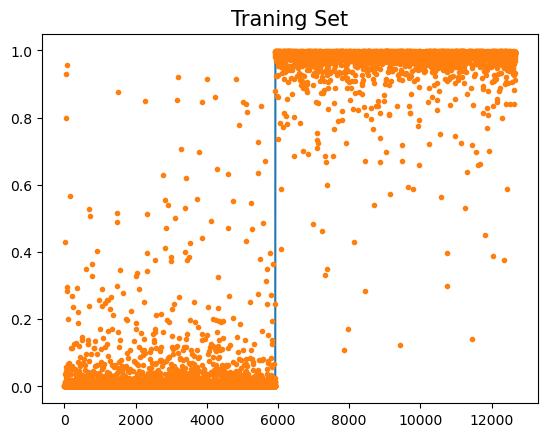

In [33]:
plt.plot(y)
plt.plot(net(X).data,'.')
plt.title('Traning Set',size=15)

Text(0.5, 1.0, 'Test Set')

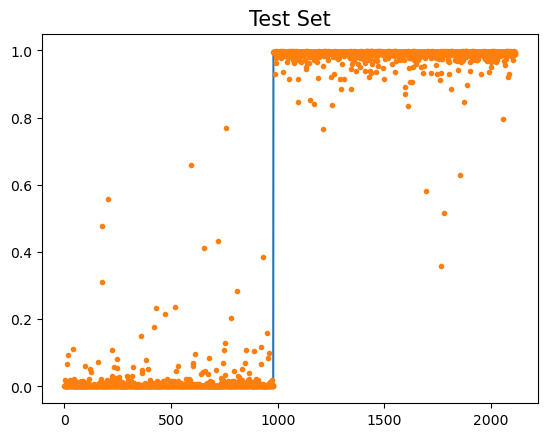

In [34]:
plt.plot(yy)
plt.plot(net(XX).data,'.')
plt.title('Test Set',size=15)

# 6. MNIST (GPU)

In [35]:
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=128)
#--#
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
#--#
net.to("cuda:0")
for epoc in range(5): 
    for xi,yi in dl: 
        ## 1
        netout = net(xi.to("cuda:0")) 
        ## 2
        loss = loss_fn(netout,yi.to("cuda:0")) 
        ## 3
        loss.backward()
        ## 4
        optimizr.step()
        optimizr.zero_grad()

Text(0.5, 1.0, 'Training Set')

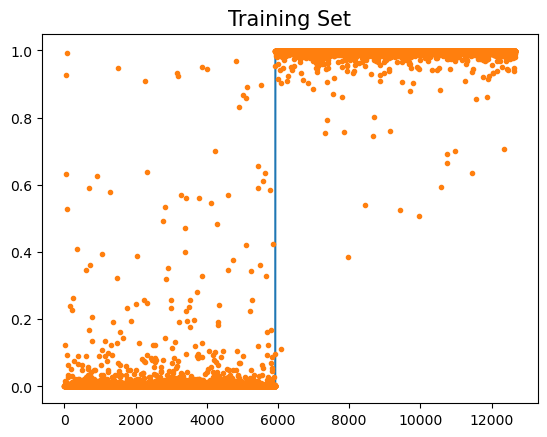

In [36]:
net.to("cpu")
plt.plot(y)
plt.plot(net(X).data,'.')
plt.title("Training Set",size=15)

Text(0.5, 1.0, 'Test Set')

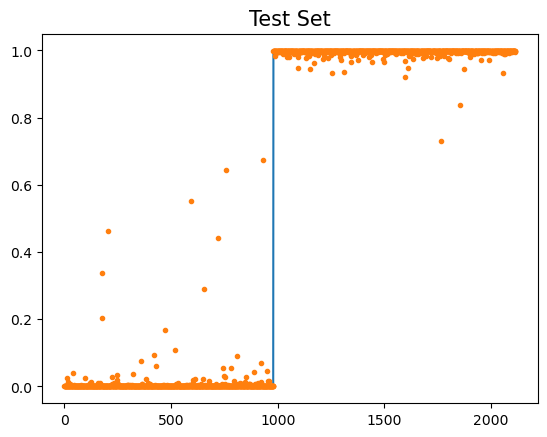

In [37]:
#net.to("cpu")
plt.plot(yy)
plt.plot(net(XX).data,'.')
plt.title("Test Set",size=15)